Multi-label image classification:
- Assign one or more class labels must be predicted for each image.

### Import Modules

In [268]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

### Create dataset

In [269]:
# Set paths to data
PROJ_ROOT = os.path.join(os.pardir)

jpg_image_path = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train-jpg')
                            + '\\{}' + '.jpg')

jpg_image_path_folder = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train-jpg'))

tif_image_path = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train-tif-v2')
                            + '\\{}' + '.tif')

tif_image_path_folder = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train-tif-v2'))

image_tags_path = os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train_v2.csv')

save_data_path = str(os.path.join(PROJ_ROOT,
                            'data',
                            'processed')
                             + '\\{}')

save_model_path = str(os.path.join(PROJ_ROOT,
                            'models')
                             + '\\{}')

In [270]:
# create a mapping of tags to integers given the loaded mapping file
def create_tag_mapping(tag_mapping_csv):
    '''
    Input the raw csv listing image files and their associated tags.
    Output a dictionary that maps tags to integers, and a dictionary
    that maps integers to tags (inverse of first dictionary).
    '''
    
    # create a set of all known tags
    all_tags = set()
    
    for i in range(len(tag_mapping_csv)):
        
        # convert spaced separated tags into an array of tags
        tags = tag_mapping_csv['tags'][i].split(' ')
        
        # add tags to the set of known tags
        all_tags.update(tags)
        
    # convert set of tags to a list to list
    all_tags = list(all_tags)
    
    # order set alphabetically
    all_tags.sort()
    
    # dict that maps tags to integers, and the reverse
    tags_map = {all_tags[i]:i for i in range(len(all_tags))}
    inv_tags_map = {i:all_tags[i] for i in range(len(all_tags))}
    
    return tags_map, inv_tags_map

In [271]:
# create a mapping of filename to a list of tags
def create_file_mapping(tag_mapping_csv):
    '''
    Input the raw csv listing image files and their associated tags.
    Output dictionary with image names as keys and split tags as values.
    '''
    mapping = dict()
    for i in range(len(tag_mapping_csv)):
        
        name, tags = tag_mapping_csv['image_name'][i], tag_mapping_csv['tags'][i]
        mapping[name] = tags.split(' ')
        
    return mapping

In [272]:
# create a one hot encoding for one list of tags
def one_hot_encode(tags, mapping):
    '''
    Input list of tags associated with an image and the tag mappings.
    Output an array of 0s and 1s, having 1s where the index of the 1
    matches the index of the mapping dicionary of that tag.
    '''
    # create empty vector
    encoding = np.zeros(len(mapping), dtype='uint8')
    
    # mark 1 for each tag in the vector
    for tag in tags:
        encoding[mapping[tag]] = 1
        
    return encoding

In [273]:
# load all images into memory
def make_dataset(path, file_mapping, tag_mapping, image_target_size=(16,16)):
    '''
    Input 
    ''' 
    photos, targets = list(), list()
    
    # enumerate files in the directory
    for filename in tqdm(os.listdir(path)[:5000]):
        
        # load image
        photo = load_img(path + '\\' + filename, target_size=image_target_size)
        
        # convert to numpy array
        photo = img_to_array(photo, dtype='uint8')
        
        # get tags
        tags = file_mapping[filename[:-4]]
        
        # one hot encode tags
        target = one_hot_encode(tags, tag_mapping)
        
        # store
        photos.append(photo)
        targets.append(target)
        
    X = np.asarray(photos, dtype='uint8')
    y = np.asarray(targets, dtype='uint8')
    
    return X, y

In [274]:
# load the mapping file
filename = 'train_v2.csv'
tag_mapping_csv = pd.read_csv(image_tags_path)

# create a mapping of tags to integers
tag_mapping, _ = create_tag_mapping(tag_mapping_csv)

# create a mapping of filenames to tag lists
file_mapping = create_file_mapping(tag_mapping_csv)

# load the jpeg images
folder = jpg_image_path_folder
X, y = make_dataset(folder, file_mapping, tag_mapping, image_target_size=(16,16))

print('X shape:', X.shape, 'y shape:', y.shape)

# save both arrays to one file in compressed format
np.savez_compressed(save_data_path.format('planet_data_5000.npz'), X, y)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 528.69it/s]


X shape: (5000, 16, 16, 3) y shape: (5000, 17)


In [275]:
tag_mapping, inv_tags_map = create_tag_mapping(tag_mapping_csv)

In [276]:
tag_mapping

{'agriculture': 0,
 'artisinal_mine': 1,
 'bare_ground': 2,
 'blooming': 3,
 'blow_down': 4,
 'clear': 5,
 'cloudy': 6,
 'conventional_mine': 7,
 'cultivation': 8,
 'habitation': 9,
 'haze': 10,
 'partly_cloudy': 11,
 'primary': 12,
 'road': 13,
 'selective_logging': 14,
 'slash_burn': 15,
 'water': 16}

### Load dataset

In [277]:
# load train and test dataset
def load_dataset(dataset_name, test_size=0.3, random_state=42):
    '''
    Input the name of a previously created dataset (e.g. planet_data_5000.npz)
    Split the dataset into train and test sets and return.
    '''
    
    # load dataset
    data = np.load(save_data_path.format(dataset_name))
    X, y = data['arr_0'], data['arr_1']
    
    # separate into train and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    print('X_train shape:', X_train.shape,
          'X_test shape:', X_test.shape,
          'y_train shape:', y_train.shape,
          'y_test shape:', y_test.shape)
    
    return X_train, y_train, X_test, y_test

### Evaluation Criteria

In [278]:
# Evaluation
from sklearn.metrics import fbeta_score

In [279]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [280]:
# make all one predictions
train_yhat = np.asarray([np.ones(y_train.shape[1]) for _ in range(y_train.shape[0])])
test_yhat = np.asarray([np.ones(y_test.shape[1]) for _ in range(y_test.shape[0])])

In [281]:
train_score = fbeta_score(y_train, train_yhat, 2, average='samples')
test_score = fbeta_score(y_test, test_yhat, 2, average='samples')
print('All Ones: train=%.3f, test=%.3f' % (train_score, test_score))

All Ones: train=0.485, test=0.483


- Must create an fbeta score function that can be used by keras:

In [282]:
from keras import backend

# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

In [284]:
train_score = fbeta(backend.variable(y_train), backend.variable(train_yhat)).eval(session=K.get_session())
test_score = fbeta(backend.variable(y_test), backend.variable(test_yhat)).eval(session=K.get_session())
print('All Ones (keras): train=%.3f, test=%.3f' % (train_score, test_score))

All Ones (keras): train=0.485, test=0.483


### Baseline Model

- VGG-type structure:
https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/
    - Blocks of convolutional layers with 3x3 filters, followed by max pooling layer - pattern repeats with a doubling of number of filters with each block added.
    - Specifically, each block has two convolutional layers with 3x3 filters, ReLU activation, and He weight initialization (with same padding)
    - Output feature maps have the same width and height 
    - These blocks are followed by a max pooling layer with 3x3 kernel
    - 3 of these blocks are used with 32, 64, and 128 filters
    - Output of final pooling layer is flattened and fed to fully connected layer for interpretation then lastly fed to an output layer for prediction.
    - The model must produce a 17 element vector (17 tags/classes) with a prediction between 0 and 1 for each output tag/class.
    - Sigmoid activation function in the output layer (multi-label classification) and optimize binary cross entropy loss function
    - Model is optimized using mini-batch stochastic gradient descent 
        - Conservative learning rate of 0.01
        - Momentum of 0.9
        - Model keeps track of 'fbeta' metric during training
        
        
- How it works:
     - Convolution layers:
         - Filter of small size is moved across the image and convolution operations are performed
         - Convolutional operations are element-wise matrix multiplication between the filter values and the pixels in the image, with the resultant values being summed
     - Pooling (downsampling) layers:
         - Used to downsample the image
         - Images contain many pixel values, it is typically easier for the network to learn the features if the image size is progressively reduced
         -  Reduces number of parameters and therefore computation
         - Also helps avoid overfitting
         - Max pooling selects maximum value, average pooling (rarely used) takes an average...
         

In [285]:
import sys
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.optimizers import Adam

In [286]:
# define cnn model
def define_model(dropout, adam_opt, in_shape=(16, 16, 3), out_shape=17):
    
    # Initiate model as sequential - will be a linear stack of layers
    model = Sequential()
    
    # Add first block
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    # dropout if set
    if dropout == True:
        model.add(Dropout(0.2))
    
    # Add second block
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # dropout if set
    if dropout == True:
        model.add(Dropout(0.2))
    
    # Add third block
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    # dropout if set
    if dropout == True:
        model.add(Dropout(0.2))
    
    # Flatten (to 1D vector) and feed to fully connected layer (relu activation)
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    # dropout if set
    if dropout == True:
        model.add(Dropout(0.5))
    
    # feed to output layer (sigmoid)
    model.add(Dense(out_shape, activation='sigmoid'))
    
    # Initiate optimization
    if adam_opt == True:
        opt = Adam()
    else:
        opt = SGD(lr=0.01, momentum=0.9)
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    
    return model

In [287]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
    
    # plot loss
    ax[0].set_title('Cross Entropy Loss')
    ax[0].plot(history.history['loss'], color='blue')
    ax[0].plot(history.history['val_loss'], color='orange')
    ax[0].legend(['train', 'test'], loc='upper left')
    
    # plot accuracy
    ax[1].set_title('Fbeta')
    ax[1].plot(history.history['fbeta'], color='blue')
    ax[1].plot(history.history['val_fbeta'], color='orange')
    ax[1].legend(['train', 'test'], loc='upper left')
    
    # save plot to file
    # filename = sys.argv[0].split('/')[-1]
    # pyplot.savefig(filename + '_plot.png')
    
    plt.show()

In [290]:
# function for evaluating models
def run_test_harness(dataset_name,
                     model_name,
                     in_shape,
                     epochs,
                     dropout=False,
                     augment=False,
                     adam_opt=False):
    
    # load dataset
    X_train, y_train, X_test, y_test = load_dataset(dataset_name)
    
    # create data generator(s)
    if augment == True:
        train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, vertical_flip=True, rotation_range=90)
        test_datagen = ImageDataGenerator(rescale=1.0/255.0)
        
         # prepare iterators
        train_it = train_datagen.flow(X_train, y_train, batch_size=128)
        test_it = test_datagen.flow(X_test, y_test, batch_size=128)
        
    else:
        # no augmentation
        datagen = ImageDataGenerator(rescale=1.0/255.0)
        
        # prepare iterators
        train_it = datagen.flow(X_train, y_train, batch_size=128)
        test_it = datagen.flow(X_test, y_test, batch_size=128)
    
    model = define_model(dropout=dropout, adam_opt=adam_opt, in_shape=in_shape, out_shape=17)
    
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=epochs, verbose=0)
    
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    
    # save model
    model.save(save_model_path.format(model_name))
    
    # learning curves
    summarize_diagnostics(history)
    
    # make predictions for test data
    predictions = model.predict_generator(test_it, steps=len(test_it))
    
    return predictions

X_train shape: (3500, 16, 16, 3) X_test shape: (1500, 16, 16, 3) y_train shape: (3500, 17) y_test shape: (1500, 17)
> loss=0.186, fbeta=0.733


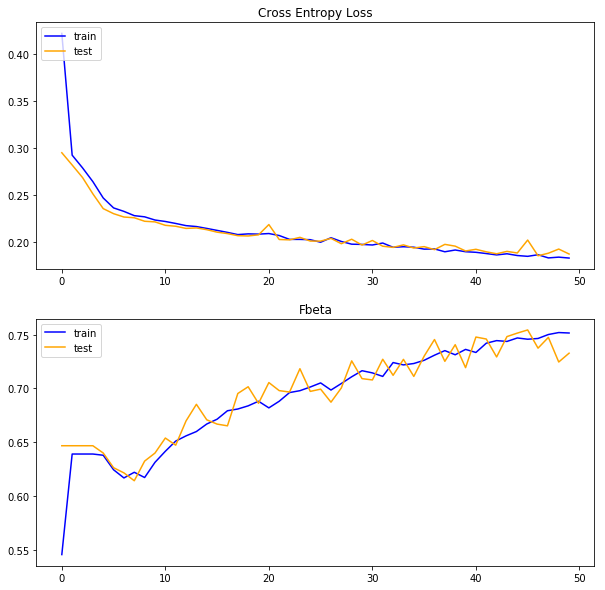

In [291]:
# entry point, run the test harness
dataset_name = 'planet_data_5000.npz'
model_name = 'base_model.h5'
in_shape = (128, 128, 3)
base_predictions = run_test_harness(dataset_name,
                                    model_name,
                                    in_shape,
                                    epochs=50,
                                    dropout=False,
                                    augment=False,
                                    adam_opt=False)

### Dropout Regularization
- Computationally cheap method to regularize a deep neural network
- Probabilistically remove (i.e. drop out) inputs to a layer
- Effectively simulates a large number of networks with very different structures which makes the modes in a network generally more robust to the inputs
- Avoid overfitting
https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/
- Can apply a small amount of dropout after each block - more dropout is applied to the fully connected layers (near the output)

(3500, 16, 16, 3) (1500, 16, 16, 3) (3500, 17) (1500, 17)
> loss=0.166, fbeta=0.777


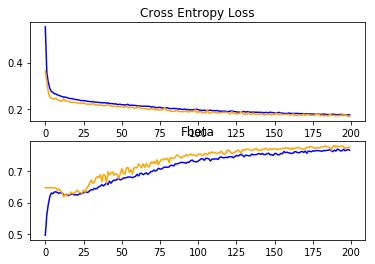

In [183]:
dataset_name = 'planet_data_5000.npz'
model_name = 'dropout_model.h5'
in_shape = (128, 128, 3)
# 200 epochs given that we expect rate of learning to slow with dropout
run_test_harness(dataset_name,
                 model_name,
                 in_shape,
                 epochs=200,
                 dropout=True,
                 augment=False,
                 adam_opt=False)

### Image Data Augmentation
- Artificially expand size of training dataset by creating modified versions of images in the original dataset
- Can help models ability to generalize
- Can also act as a regularization method
- Can be specified as arguments to the ImageDataGenerator
- Should not be used on test dataset

(3500, 16, 16, 3) (1500, 16, 16, 3) (3500, 17) (1500, 17)
> loss=0.203, fbeta=0.748


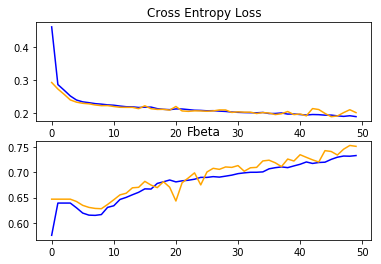

In [186]:
dataset_name = 'planet_data_5000.npz'
model_name = 'augment_model.h5'
in_shape = (128, 128, 3)
run_test_harness(dataset_name,
                 model_name,
                 in_shape,
                 epochs=200,
                 dropout=False,
                 augment=True,
                 adam_opt=False)

### Dropout Regularization and Image Data Augmentation

(3500, 16, 16, 3) (1500, 16, 16, 3) (3500, 17) (1500, 17)
> loss=0.163, fbeta=0.794


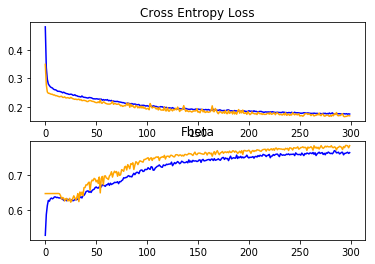

In [188]:
dataset_name = 'planet_data_5000.npz'
model_name = 'dropout_augment_model.h5'
in_shape = (128, 128, 3)
run_test_harness(dataset_name,
                 model_name,
                 in_shape,
                 epochs=350,
                 dropout=True,
                 augment=True,
                 adam_opt=False)

### Adam Optimizer
- ............................

(3500, 16, 16, 3) (1500, 16, 16, 3) (3500, 17) (1500, 17)
> loss=0.365, fbeta=0.785


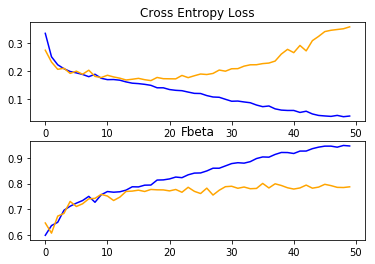

In [208]:
dataset_name = 'planet_data_5000.npz'
model_name = 'adam_model.h5'
in_shape = (128, 128, 3)
run_test_harness(dataset_name,
                 model_name,
                 in_shape,
                 epochs=50,
                 dropout=False,
                 augment=False,
                 adam_opt=True)

### Adam Optimizer and dropout regularization

(3500, 16, 16, 3) (1500, 16, 16, 3) (3500, 17) (1500, 17)
> loss=0.357, fbeta=0.818


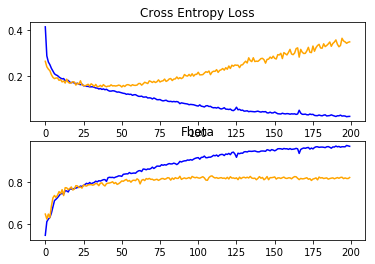

In [209]:
dataset_name = 'planet_data_5000.npz'
model_name = 'adam_dropout_model.h5'
in_shape = (128, 128, 3)
run_test_harness(dataset_name,
                 model_name,
                 in_shape,
                 epochs=200,
                 dropout=True,
                 augment=False,
                 adam_opt=True)

### Adam Optimizer and image augmentation

(3500, 16, 16, 3) (1500, 16, 16, 3) (3500, 17) (1500, 17)
> loss=0.210, fbeta=0.814


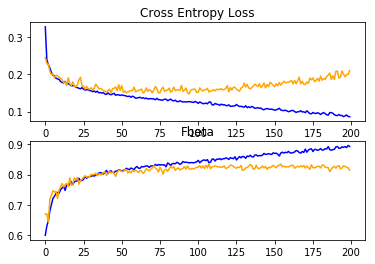

In [210]:
dataset_name = 'planet_data_5000.npz'
model_name = 'adam_augment_model.h5'
in_shape = (128, 128, 3)
run_test_harness(dataset_name,
                 model_name,
                 in_shape,
                 epochs=200,
                 dropout=False,
                 augment=True,
                 adam_opt=True)

### Adam Optimizer, dropout regularization, and image augmentation

(3500, 16, 16, 3) (1500, 16, 16, 3) (3500, 17) (1500, 17)
> loss=0.152, fbeta=0.842


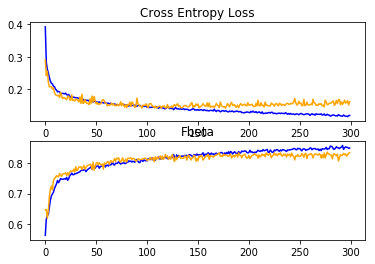

In [211]:
dataset_name = 'planet_data_5000.npz'
model_name = 'adam_dropout_augment_model.h5'
in_shape = (128, 128, 3)
run_test_harness(dataset_name
                 model_name,
                 in_shape,
                 epochs=350,
                 dropout=True,
                 augment=True,
                 adam_opt=True)

### Using the model further...

In [ ]:
#model = load_model('model.h5')

In [ ]:
prediction_labels = []
_, inv_tags_map = create_tag_mapping(tag_mapping_csv)
    
for prediction in predictions:
        
    labels = [inv_tags_map[i] for i, value in enumerate(prediction) if value > thresholds[i]]
    prediction_labels.append(labels)
    
plot_prediction_by_tag(prediction_labels)

In [ ]:
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(128, 128))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 128, 128, 3)
    # center pixel data
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    return img

In [ ]:
# predict the class
# result = model.predict(img)

In [ ]:
# convert a prediction to tags
thresholds = [0.2] * len(tag_mapping)

def prediction_to_tags(inv_mapping, prediction):
    # round probabilities to {0, 1}
    values = prediction.round()
    # collect all predicted tags
    tags = [inv_mapping[i] for i in range(len(values)) if values[i] == 1.0]
    return tags

In [ ]:
# load an image and predict the class
def run_example(inv_mapping):
    # load the image
    img = load_image('sample_image.jpg')
    # load model
    model = load_model('final_model.h5')
    # predict the class
    result = model.predict(img)
    print(result[0])
    # map prediction to tags
    tags = prediction_to_tags(inv_mapping, result[0])
    print(tags)
 
# load the mapping file
filename = 'train_v2.csv'
mapping_csv = read_csv(filename)
# create a mapping of tags to integers
_, inv_mapping = create_tag_mapping(mapping_csv)
# entry point, run the example
run_example(inv_mapping)